Multimedia Security and Privacy  
Lea Heiniger  
06.04.2023 

In [1]:
# Import useful libraries
import cv2
import numpy as np
import skimage.color as clr
import skimage.transform as trf
import skimage.util as uti
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from copy import copy
from matplotlib import pyplot as plt
import random

(-0.5, 63.5, 63.5, -0.5)

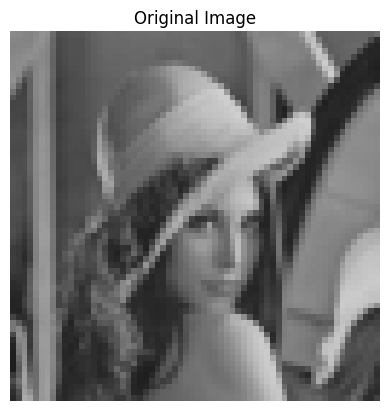

In [2]:
# read in the image, convert it to the right size 64x64 and plot for verification
im = cv2.imread('lena.png')
im = clr.rgb2gray(im)
im = uti.img_as_ubyte(trf.resize(im, (64,64)))

plt.imshow(im, vmin=0, vmax=255, cmap = "gray")
plt.title('Original Image')
plt.axis('off')

In [3]:
# chunk image procedure in blocks 4x4 and verify it works
blk_size = 4
n_blk = int(64/blk_size)
#fig, axs = plt.subplots(n_blk, n_blk)
#for i in range(n_blk**2):
#    axs[int(i//n_blk), int(i%n_blk)].imshow(im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)], vmin=0, vmax=255)
#    axs[int(i//n_blk), int(i%n_blk)].axis('off')

(-0.5, 63.5, 63.5, -0.5)

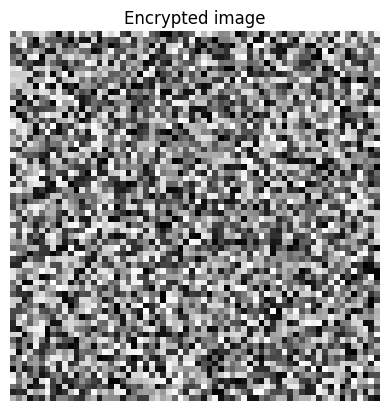

In [4]:
# Encryption of each 4x4 blocks (16 bytes of data) by AES-256 method and show encrypted image
enc_im = copy(im)
key = get_random_bytes(16)
cipher = AES.new(key, AES.MODE_EAX)
nonce =cipher.nonce
for i in range(n_blk**2):
    subim = im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)]
    enc_im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)] = np.reshape(np.frombuffer(cipher.encrypt(subim.tobytes()), dtype = subim.dtype), subim.shape)
plt.imshow(enc_im, vmin=0, vmax=255, cmap = "gray")
plt.title('Encrypted image')
plt.axis('off')

In [5]:
def gaussian_noise(N, M , mu, sigma) :
    ''' function that generate a N by M array of Gaussian noise with parameters mu and sigma '''

    return np.asarray([[np.random.normal(mu, sigma) for i in range(M)] for j in range(N)])


In [6]:
# one bit attack
enc_im_one_bit = copy(enc_im)
enc_im_one_bit[0,0] = random.randint(0,256)

# aditive gaussian white noise attack
enc_im_agwn = copy(enc_im)
N, M = enc_im.shape[0],enc_im.shape[1]
noise = gaussian_noise(N, M, 0, 1)
enc_im_agwn = np.asarray([[max(min(255,enc_im_agwn[j,i] + noise[j,i]),0) for i in range(M)] for j in range(N)])

(-0.5, 63.5, 63.5, -0.5)

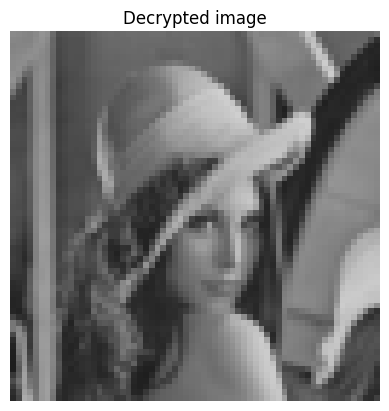

In [7]:
# Decryption and show decrypted image
dec_im = copy(enc_im)
cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
for i in range(n_blk**2):
    subim = enc_im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)]
    dec_im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)] = np.reshape(np.frombuffer(cipher.decrypt(subim.tobytes()), dtype = subim.dtype), subim.shape)
plt.imshow(dec_im, vmin=0, vmax=255, cmap = "gray")
plt.title('Decrypted image')
plt.axis('off')


The decrypted image is exactly the same as the original when there is no attack

(-0.5, 63.5, 63.5, -0.5)

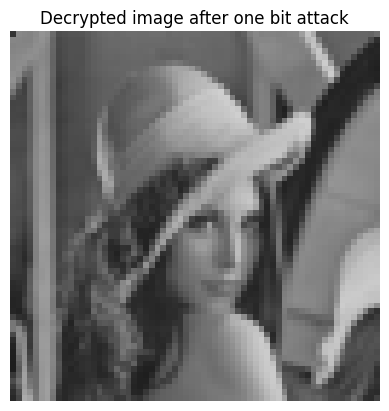

In [8]:
dec_im = copy(enc_im_one_bit)
cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
for i in range(n_blk**2):
    subim = enc_im_one_bit[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)]
    dec_im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)] = np.reshape(np.frombuffer(cipher.decrypt(subim.tobytes()), dtype = subim.dtype), subim.shape)
plt.imshow(dec_im, vmin=0, vmax=255, cmap = "gray")
plt.title('Decrypted image after one bit attack')
plt.axis('off')

We can see that when there is only one bit modified the decrypted image differs by one bit (the same one modified on the encrypted image)

(-0.5, 63.5, 63.5, -0.5)

/usr/local/lib/python3.10/dist-packages/matplotlib/image.py:484: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


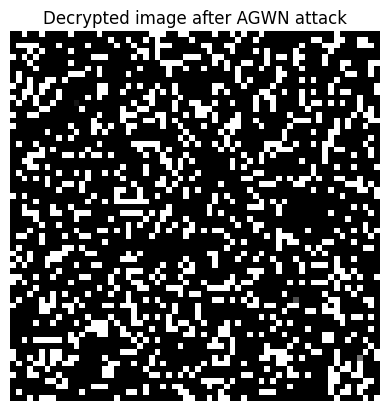

In [9]:
dec_im = copy(enc_im_agwn)
cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
for i in range(n_blk**2):
    subim = enc_im_agwn[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)]
    dec_im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)] = np.reshape(np.frombuffer(cipher.decrypt(subim.tobytes()), dtype = subim.dtype), subim.shape)
plt.imshow(dec_im, vmin=0, vmax=255, cmap = "gray")
plt.title('Decrypted image after AGWN attack')
plt.axis('off')

However, when noise is added to the entire encrypted image, the original image cannot be restored.  
We can conclude that classical cryptographic protocols are not adapted to imagesand that it would be better to use other methods less sensitive to noise.